# 04 Stochastic Oscillator.

* **Original Text**: https://excelsior-cjh.tistory.com/111?category=975542 [EXCELSIOR]
* **Ant House**: https://www.slideshare.net/anthouseadmin/
* **Final Edit**: 2021-08-03


In [3]:
!pip3 install --user pandas
!pip3 install --user html5lib
!pip3 install --user BeautifulSoup4
!pip3 install --user plotly
!pip3 install --user nbformat

In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}

def get_url(item_name, code_df): 
  code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
  url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
  print("요청 URL = {}".format(url)) 
  return url

def get_html_table_symbol(url):
  response = requests.get(url, headers=headers)
  html = bs(response.text, 'lxml')
  html_table = html.select('table')
  len(html_table)
  return str(html_table)

# 1: Get event_code from 상장법인목록.xls
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) 
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

# 2. Get stock data from naver finance
item_name='삼성전자' 
url = get_url(item_name, code_df)

df = pd.DataFrame()
for page in range(1, 21):
  pg_url = '{url}&page={page}'.format(url=url, page=page)
  table = get_html_table_symbol(pg_url)
  df = df.append(pd.read_html(table, header=0)[0], ignore_index=True)
df = df.dropna()

# 3. Rename columns
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
df['date'] = pd.to_datetime(df['date']) 
df = df.sort_values(by=['date'], ascending=True) 

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=005930


## Dataframe 문법

* `dropna(axis=)`: NaN 있는 행/열 제거 
* `assign()`: column 추가
* `rolling(window=n)`: n일 단순 이동평균 (Simple moving average (SMA)) 
* `ewm(span=x)`: Provide exponential weighted functions
* `ewm(span=m).mean()`: m일 지수 이동평균 (Exponetial moving average (EMA))

In [13]:
def get_stochastic(df, n=15, m=5, t=3):
  df = pd.DataFrame(df)
  ndays_high = df.high.rolling(window=n, min_periods=1).max()
  ndays_low = df.low.rolling(window=n, min_periods=1).min()

  # Fast%K
  kdj_k = ((df.close - ndays_low)/(ndays_high-ndays_low))*100
  # Fast%D
  kdj_d = kdj_k.ewm(span=m).mean()
  # Slow%D
  kdj_j = kdj_d.ewm(span=t).mean()

  df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()

  return df

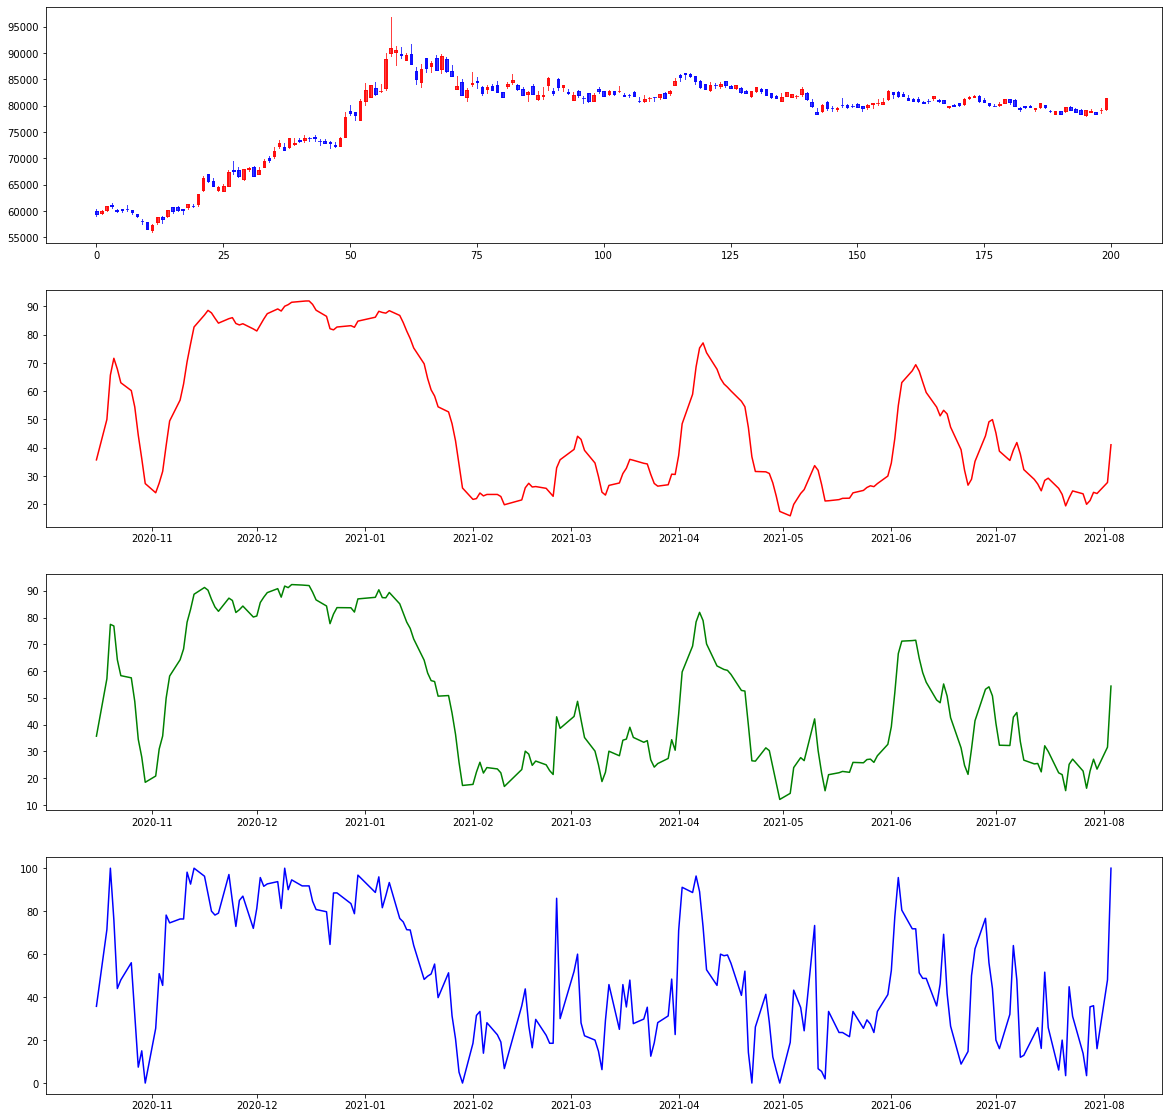

In [17]:
import datetime
from mplfinance.original_flavor import candlestick2_ohlc
import matplotlib.pyplot as plt

df = get_stochastic(df)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

ax2.plot(df.date, df['kdj_j'], 'r',label='Slow%D')
ax3.plot(df.date, df['kdj_d'], 'g',label='Fast%D')
ax4.plot(df.date, df['kdj_k'], 'b',label='Fast%K')


candlestick2_ohlc(ax1, df['open'],df['high'],df['low'], df['close'], width=0.5, colorup='r', colordown='b')


plt.show()
